# Lecture outline

1. Resources for learning Python
1. Experimental framework implementation
1. Performance evaluation
1. Assignments

# 1. Resources for learning Python, numpy, pandas and Jupyter notebooks

**Read this guide/tutorial first**: [Running Jupyter Notebooks With The Anaconda Python Distribution](https://www.datacamp.com/community/tutorials/tutorial-jupyter-notebook) and please note that:
* You can skip parts on pip & docker. 
* Install Anaconda (with Python 3) only.
* Do not hesitate to follow links included in the guide.

**Then**, consider proceeding to:

1. [Intro to Python for Data Science](https://www.datacamp.com/courses/intro-to-python-for-data-science) - I do not have personal experience with this course, but since it was referenced in the DataCamp guide, it should be OK (and free)
1. [Python Data Science Cookbook](https://www.packtpub.com/big-data-and-business-intelligence/python-data-science-cookbook) - book I can highly recommend
1. [Python for Data Science and Machine Learning Bootcamp](https://www.udemy.com/python-for-data-science-and-machine-learning-bootcamp/) - Good Udemy course with examples in Jupyter notebooks (often in sale for ca. $10)
1. Last, but not least, use *Google*. Feel free to type in name of module you are interested in and you will find lots of helpful resources. Official documentation sites (e.g. for [NumPy](https://docs.scipy.org/doc/numpy/reference/)) are great places to start as well.

**Good luck!**

Little bit of motivation:

<img src="img/matlab_vs_python_2020.png">

Source: [Google Trends](https://trends.google.com/trends/explore?date=all&q=%2Fm%2F053_x,%2Fm%2F05z1_)

Disclaimer: _I am very happy user of MATLAB, as well_ :-)

# 2. Experimental framework implementation

## Best practice to implement and test $n$ heuristics and $m$ objective functions?

* There are some common characteristics for the two most important _things_ in our framework
  * Heuristics - store the best found solution, manage stop criterion, etc.
  * Objective functions - store $f^*$, lower/upper bounds, etc.
* Every specific heuristic or obj. function implements its own search space exploration or evaluation, neighbourhood generation, etc.
* Thus, the object-oriented design should help us to separate these concerns as much as possible and also to keep us sane.

<img src="img/oop_design.png">

## Example: two objective functions and generalized Shoot&Go


### Objective functions

#### 1. AirShip

* Same as on the previous class, i.e. we will **minimize** obj. function values
* implemented as ``class AirShip(ObjFun)`` in ``src/objfun_airship.py``

In [1]:
# Import path to source directory (bit of a hack in Jupyter)
import sys
import os
pwd = %pwd
sys.path.append(os.path.join(pwd, os.path.join('..', 'src')))

# Ensure modules are reloaded on any change (very useful when developing code on the fly)
%load_ext autoreload
%autoreload 2

In [2]:
from objfun_airship import AirShip
airship = AirShip()

In [3]:
airship.get_bounds()

[0, 799]

In [4]:
airship.get_fstar()

-100

In [5]:
airship.generate_point()

8

In [6]:
airship.evaluate(50)

-100.0

#### 2. $\sum \mathbf{x}$

* Just as demonstration of vectorized lower/upper bounds
* implemented as ``class Sum(ObjFun)`` in ``src/objfun_sum.py``

In [7]:
from objfun_sum import Sum
of_sum = Sum([0, 0, 0, 0], [10, 10, 10, 10])

In [8]:
x = of_sum.generate_point()
print(x)
print(of_sum.evaluate(x))

[4, 1, 9, 9]
23


In [9]:
print(of_sum.get_neighborhood(x, 1))

[[3, 1, 9, 9], [5, 1, 9, 9], [4, 0, 9, 9], [4, 2, 9, 9], [4, 1, 8, 9], [4, 1, 10, 9], [4, 1, 9, 8], [4, 1, 9, 10]]


In [10]:
print(of_sum.get_neighborhood(x, 2))

AssertionError: Sum(x) supports neighbourhood with diameter = 1 only

^^ This behaviour is intended. See code for details.

In [11]:
of_sum.get_neighborhood([0, 0, 0, 0], 1)

[[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]]

### Generalized Shoot&Go: $\mathrm{SG}_{hmax}$

* Shoot & Go heuristic (also known as *Iterated Local Search*, *Random-restart hill climbing*, etc)
    * $hmax \in \{ 0, 1, \ldots, \infty \}$ parameter - maximum number of local searches / hill climbs
    * note that $\mathrm{SG}_{0}$ is pure Random Shooting (Random Search)
    
* implemented as ``class ShootAndGo(Heuristic)`` in ``src/heur_sg.py``    



In [12]:
from heur_sg import ShootAndGo

In [13]:
# Random Shooting for the AirShip initialization...
demo_rs = ShootAndGo(airship, maxeval=100, hmax=0)
# ...and execution:
demo_rs.search()

{'best_y': -88.0,
 'best_x': 44,
 'neval': inf,
 'log_data': Empty DataFrame
 Columns: []
 Index: []}

# 2. Performance evaluation

## What is the recommended approach to store and analyze results of your experiments?

1. Append all relevant statistics from a single run into table (e.g. CSV file in memory or on disk), including all task and heuristic parameters 
2. Load the table into analytical tool of your choice (**data frame**, Excel or Google Docs spreadsheets, etc.)
3. Pivot by relevant parameters, visualize in tables or charts

## Demonstration

Neccessary setup first:

In [14]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

### General experiment setup

Runs selected objective function (`of`) using selected heuristic multiple times, stores and returns data (results) in a data frame.

In [15]:
def experiment(of, num_runs, hmax):
    results = []
    for i in tqdm(range(num_runs), 'Testing hmax = {}'.format(hmax)):
        result = ShootAndGo(of, maxeval=100, hmax=hmax).search() # dict with results of one run
        result['run'] = i
        result['heur'] = 'SG_{}'.format(hmax) # name of the heuristic
        result['hmax'] = hmax
        results.append(result)
    return pd.DataFrame(results, columns=['heur', 'run', 'hmax', 'best_x', 'best_y', 'neval'])

### Air Ship experiments

In [16]:
table = pd.DataFrame()
for hmax in [0, 1, 2, 5, 10, 20, 50, np.inf]:
    res = experiment(airship, 10000, hmax)
    table = pd.concat([table, res], axis=0)

**Note**: This is what you should see while experiments are in progress:

<img src="img/tqdm_progress.png">

In [17]:
table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   heur    80000 non-null  object 
 1   run     80000 non-null  int64  
 2   hmax    80000 non-null  float64
 3   best_x  80000 non-null  int64  
 4   best_y  80000 non-null  float64
 5   neval   80000 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 4.3+ MB


In [18]:
table.head()

,heur,run,hmax,best_x,best_y,neval
0,SG_0,0,0.0,40,-80.0,inf
1,SG_0,1,0.0,54,-92.0,inf
2,SG_0,2,0.0,42,-84.0,inf
3,SG_0,3,0.0,51,-98.0,inf
4,SG_0,4,0.0,48,-96.0,inf


#### What is the quality of solutions based on `hmax`?

In **tabular** form:

In [19]:
table.groupby(['hmax'])['best_y'].median()

hmax
0.0    -94.000000
1.0    -86.000000
2.0    -76.000000
5.0    -60.000000
10.0   -49.494949
20.0   -41.414141
50.0   -24.583333
inf    -25.000000
Name: best_y, dtype: float64

In [20]:
table.groupby(['hmax'])['best_y'].mean()

hmax
0.0    -92.216584
1.0    -80.270460
2.0    -71.925341
5.0    -62.900024
10.0   -55.461255
20.0   -49.135008
50.0   -38.070296
inf    -38.236560
Name: best_y, dtype: float64

Random Shooting seems to find highest quality on average. Feel free to compute other statistics instead of median and mean.

Directly as **Box-Whiskers plot**:

In [21]:
# import visualization libraries
import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

/Users/mojzes/anaconda/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<IPython.core.display.Javascript object>


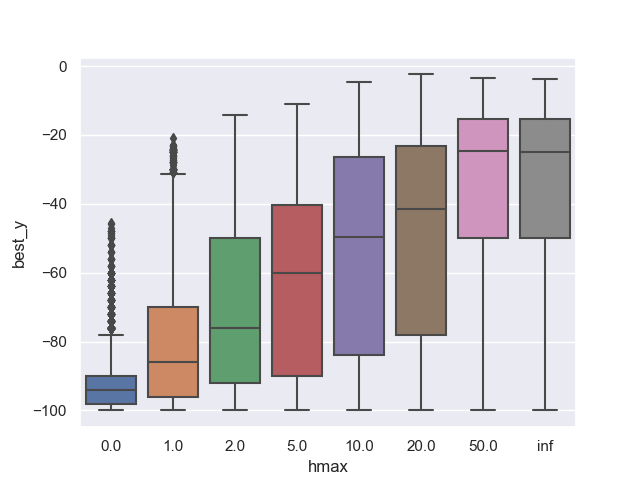

In [24]:
ax = sns.boxplot(x="hmax", y="best_y", data=table)

#### Number of evaluations (when successful), based on `hmax`?

Let's add another column, `success`:

In [25]:
table['success'] = table['neval'] < np.inf

In [26]:
table[table['success'] == True].head()

,heur,run,hmax,best_x,best_y,neval,success
5,SG_0,5,0.0,50,-100.0,77.0,True
13,SG_0,13,0.0,50,-100.0,23.0,True
21,SG_0,21,0.0,50,-100.0,64.0,True
53,SG_0,53,0.0,50,-100.0,92.0,True
55,SG_0,55,0.0,50,-100.0,72.0,True


Table:

In [27]:
table[table['success'] == True].groupby(['hmax'])['neval'].mean()

hmax
0.0     48.599824
1.0     48.693724
2.0     49.164017
5.0     47.907216
10.0    49.937208
20.0    49.373718
50.0    53.746746
inf     53.256579
Name: neval, dtype: float64

In [28]:
table[table['success'] == True].groupby(['hmax'])['neval'].median()

hmax
0.0     48.0
1.0     48.0
2.0     50.0
5.0     47.0
10.0    49.0
20.0    49.0
50.0    54.0
inf     54.0
Name: neval, dtype: float64

Shorter runs seem to be the _quickest_.

Graphically:

<IPython.core.display.Javascript object>


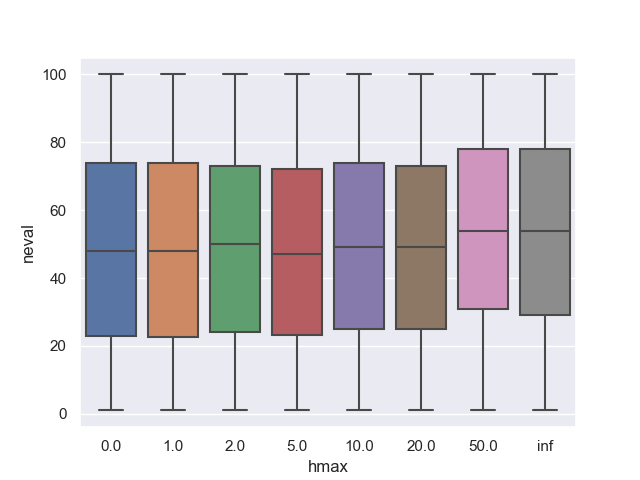

In [30]:
ax = sns.boxplot(x="hmax", y="neval", data=table[table['success'] == True])

#### Reliability

In [31]:
rel_by_hmax = table.pivot_table(
    index=['hmax'],
    values=['neval'],
    aggfunc=lambda x: len([n for n in x if n < np.inf])/len(x)
)

In [32]:
rel_by_hmax

,neval
hmax,
0.0,0.1137
1.0,0.1195
2.0,0.1195
5.0,0.1358
10.0,0.1497
20.0,0.1560
50.0,0.1844
inf,0.1824


<IPython.core.display.Javascript object>


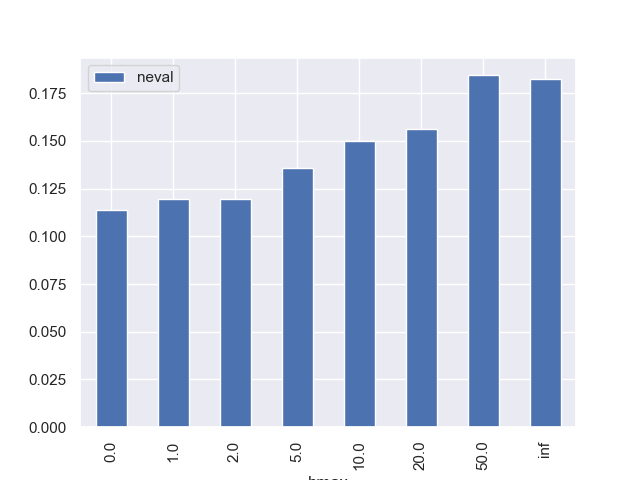

In [33]:
ax = rel_by_hmax.plot(kind='bar')

We can conclude that longer runs (almost unlimited) are the most reliable, on average.

#### Speed, normalized by reliability?

* Reliability: $REL = m/q$ where $m$ is number of successful runs and $q$ is total number of runs, $REL \in [0, 1]$
* Mean Number of objective function Evaluations: $MNE = \frac{1}{m} \sum_{i=1}^m neval_i$
* Feoktistov criterion: $FEO = MNE/REL$

In [34]:
feo_by_hmax = table.pivot_table(
    index=['hmax'],
    values=['neval'],
    aggfunc=lambda x: np.mean([n for n in x if n < np.inf])/(len([n for n in x if n < np.inf])/len(x))
    #                 ^^^   mean number of evaluations ^^^ / ^^^             reliability         ^^^^
)

In [35]:
feo_by_hmax

,neval
hmax,
0.0,427.439086
1.0,407.478861
2.0,411.414366
5.0,352.777736
10.0,333.581882
20.0,316.498192
50.0,291.468255
inf,291.976858


<IPython.core.display.Javascript object>


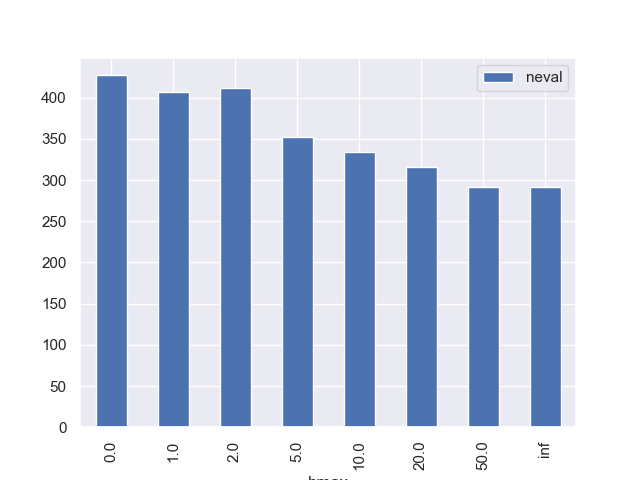

In [36]:
ax = feo_by_hmax.plot(kind='bar')

After normalization by reliability, it seems that very long run (almost infinitely) is the _fastest_.

### `sum(x)` experiments

In [37]:
table = pd.DataFrame()
for hmax in [0, 1, 2, 5, 10, 20, 50, np.inf]:
    res = experiment(of_sum, 10000, hmax)
    table = pd.concat([table, res], axis=0)

#### Quality of solutions based on hmax?

<IPython.core.display.Javascript object>


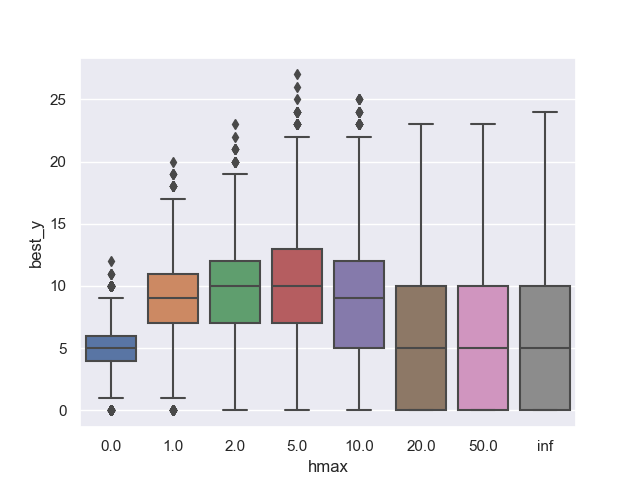

In [38]:
ax = sns.boxplot(x="hmax", y="best_y", data=table)

#### Number of evaluations (when successful), based on hmax?

In [39]:
table['success'] = table['neval'] < np.inf

<IPython.core.display.Javascript object>


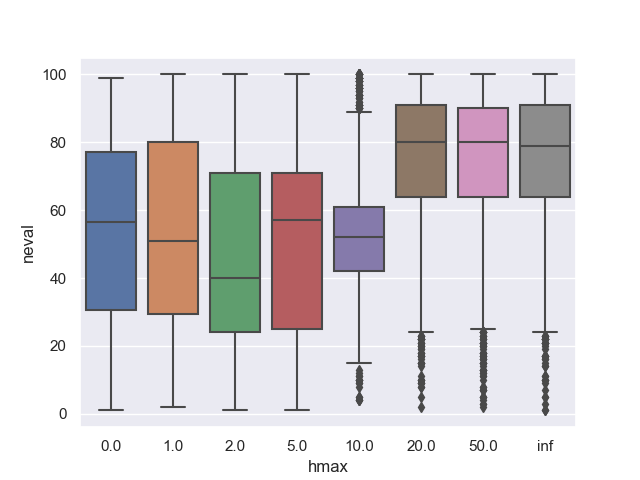

In [40]:
ax = sns.boxplot(x="hmax", y="neval", data=table[table['success'] == True])

#### Reliability?

In [41]:
rel_by_hmax = table.pivot_table(
    index=['hmax'],
    values=['neval'],
    aggfunc=lambda x: len([n for n in x if n < np.inf])/len(x)
)

In [42]:
rel_by_hmax

,neval
hmax,
0.0,0.0062
1.0,0.0034
2.0,0.0069
5.0,0.0218
10.0,0.0812
20.0,0.2777
50.0,0.2921
inf,0.2824


<IPython.core.display.Javascript object>


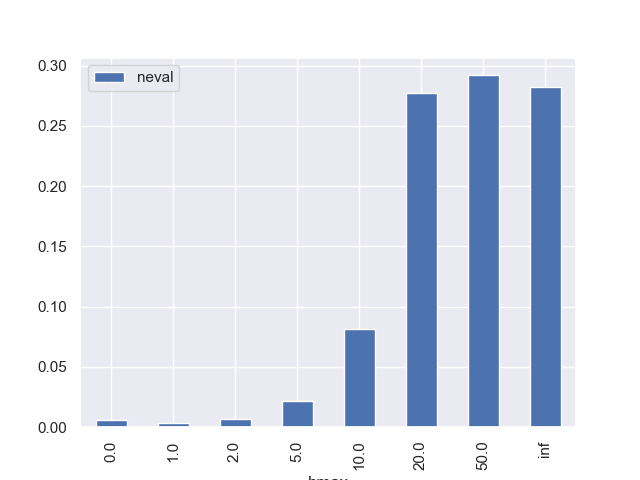

In [43]:
ax = rel_by_hmax.plot(kind='bar')

#### Feoktistov criterion?

In [44]:
feo_by_hmax = table.pivot_table(
    index=['hmax'],
    values=['neval'],
    aggfunc=lambda x: np.mean([n for n in x if n < np.inf])/(len([n for n in x if n < np.inf])/len(x))
)

<IPython.core.display.Javascript object>


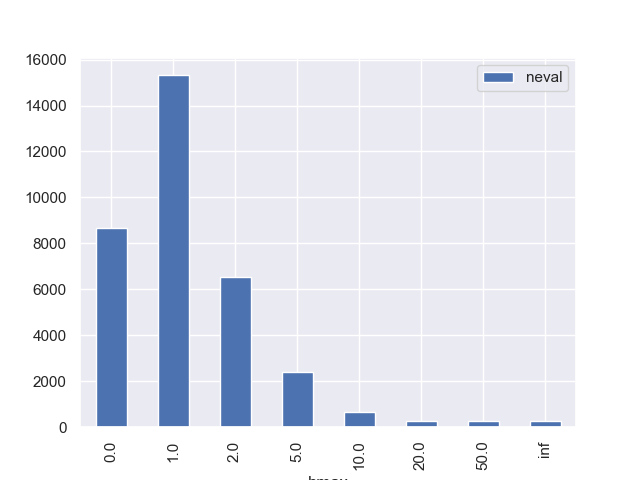

In [45]:
ax = feo_by_hmax.plot(kind='bar')

# Assignments (or rather inspiration for your own work)

1. Implement examples in this notebook on your own
1. Experiment with **neighbourhood diameter** `d` in `AirShip.get_neighborhood(x, d)`
1. Play with new heuristics in the existing framework and analyze their performance:
   1. **Random Descent**, similar to Shoot & Go, but does not follow steepest descent, chooses direction of the descent randomly instead
   1. **Taboo Search**